In [ ]:
import numpy as np
import heapq
from collections.abc import Sequence
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import time

# **Lớp Priority Queue**

In [ ]:
class PriorityQueue:
    def __init__(self):
        self.queue = []
        self.priorities = {}  # key là item, value là điểm priority
        self.index = 0   # Index dùng để lưu thứ tự add vào queue của các item có cùng priority
        self.DONE = -100000

    def insert(self, newPriority, item):
        """Thêm item cùng với điểm priority vào queue"""
        # heapq theo mặc định là min-heap nên nó sẽ tự động giữ phần tử có điểm priority thấp nhất ở trên cùng
        # Sử dụng `self._index` để giữ thứ tự chèn cho các phần tử có cùng điểm priority
        oldPriority = self.priorities.get(item)
        if oldPriority is None or newPriority < oldPriority:
            self.priorities[item] = newPriority
            heapq.heappush(self.queue, (newPriority, self.index, item))
            self.index += 1
            return True
        return False

    def removeMin(self):
        """Trả về item có điểm priority nhỏ nhất ra khỏi queue"""
        while len(self.queue) > 0:
            priority, _, item = heapq.heappop(self.queue)
            if self.priorities[item] == self.DONE:
                continue
            self.priorities[item] = self.DONE
            return item
        return None

    def empty(self):
        """Trả về True nếu tất cả item trong queue đều có Priority là DONE"""
        for i in self.priorities:
            if self.priorities[i] != self.DONE:
                return False
        return True

    def __str__(self):
        return f"{self.queue}"

    def __repr__(self):
        return f"{self.queue}"

# **Lớp biểu diễn các toạ độ (x, y)**
Trong đó:
* x là vị trí theo dòng
* y là vị trí theo cột
* Gốc tọa độ (1,1) nằm ở góc phía dưới bên trái của ma trận

In [ ]:
class Position:
    # Constructor
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def __hash__(self):
        return hash((self.x, self.y))

    def __str__(self):
        return f"({self.x}, {self.y})"

    def __repr__(self):
        return self.__str__()

# **Lớp biểu diễn các ô**

In [ ]:
class Cell:
    # Constructor
    def __init__(self, position: Position, parent=None, status="free", g=np.inf, h=0): # current cost của tất cả các ô ban đầu = 0
        self.position = position # Position object
        self.parent   = parent   # parent (object) in a path
        self.status   = status   # {'free', 'start', 'dirty', 'clean'}
        self.g        = g # current   cost
        self.h        = h # estimated cost
        self.f        = self.g + self.h # full path cost

    def __eq__(self, other):
        return self.position == other.position

    def __hash__(self):
        return hash(self.position)

    def __str__(self):
        return f"Cell({self.position}, {self.status}): g = {self.g}; h = {self.h}; f = {self.f}"

    def __repr__(self):
        return self.__str__()

# **Lớp biểu diễn đồ thị dạng Grid**

In [ ]:
class Grid(Sequence):
    # Constructor
    def __init__(self, row_num, col_num, dirty_pos, start_pos):
        super().__init__()
        self.row_num = row_num
        self.col_num = col_num
        self.dirty_pos = dirty_pos
        self.start_pos = start_pos

        self.grid = [[0 for col in range(col_num)] for row in range(row_num)]

        for row in range(1, row_num + 1):
            for col in range(1, col_num + 1):
                if Position(row, col) in dirty_pos:
                    self.grid[row_num - row][col - 1] =  Cell(Position(row, col), status="dirty")
                elif Position(row, col) == start_pos:
                    self.grid[row_num - row][col - 1] =  Cell(Position(row, col), status="start")
                else:
                    self.grid[row_num - row][col - 1] =  Cell(Position(row, col))

    def __getitem__(self, index):
        if isinstance(index, tuple) and len(index) == 2:
            row, col = index
            row = self.row_num - row
            col = col - 1
            return self.grid[row][col]
        elif isinstance(index, int):  # Trường hợp index chỉ có 1 phần tử (int)
            row = self.row_num - index
            return self.grid[row]  # Trả về toàn bộ hàng tại chỉ số index
        else:
            raise IndexError("Chỉ số không hợp lệ")

    def __setitem__(self, index, value):
        if isinstance(index, tuple) and len(index) == 2:
            row, col = index
            row = self.row_num - row
            col = col - 1
            self.grid[row][col] = value
        elif isinstance(index, int):  # Trường hợp index chỉ có 1 phần tử (int)
            row = self.row_num - index
            self.grid[row] = value
        else:
            raise IndexError("Chỉ số không hợp lệ")

    def __iter__(self):
        return iter(self.grid)

    def __len__(self):
        return len(self.grid)

    # Factory method using a Class Method
    @classmethod
    def create_grid(cls):
        # Nhập kích thước ma trận A(mxn)
        while True:
            try:
                m, n = input("Nhập kích thước ma trận (mxn): ").split("x")
                m, n = int(m), int(n)
                if m <= 0 or n <= 0:
                    raise ValueError
            except ValueError:
                print("Kích thước ma trận không hợp lệ. Vui lòng nhập lại.")
            else:
                break

        # Nhập số lượng ô "dirty" với vị trí ngẫu nhiên
        while True:
            dirty_num = input("Nhập số lượng ô dirty: ")
            try:
                dirty_num = int(dirty_num)
                if dirty_num <= 0:
                    raise ValueError
            except ValueError:
                print("Số lượng ô dirty không hợp lệ. Vui lòng nhập lại.")
            else:
                break

        # Khởi tạo vị trí ngẫu nhiên cho các ô "dirty" và ô "start"
        occupied_positions = set()
        dirty_pos = []
        for _ in range(dirty_num):
            while True:
                x, y = np.random.randint(1, m), np.random.randint(1, n) # A random integer in range [start, end] including the end points.
                if (x, y) not in occupied_positions:
                    occupied_positions.add((x, y))
                    dirty_pos.append(Position(x, y))
                    break

        while True:
            x, y = np.random.randint(1, m), np.random.randint(1, n)
            if (x, y) not in occupied_positions:
                occupied_positions.add((x, y))
                start_pos = Position(x, y)
                break

        return cls(m, n, dirty_pos, start_pos)

    def clear_grid(self):
        for i in range(self.row_num):
            for j in range(self.col_num):
                self.grid[i][j].parent = None
                self.grid[i][j].g = np.inf
                self.grid[i][j].h = 0
                self.grid[i][j].f = np.inf

    def display_grid(self, path=None):
        # Map status to colors
        color_map = {
            "start": 'green',   # Starting point
            "dirty": 'blue',    # Dirty cell
            "free": 'white',    # Free cell
            "clean": 'lightblue'      # Cleaned cell
        }

        color_matrix = []
        for i in range(self.row_num):
            row = []
            for j in range(self.col_num):
                status = self.grid[i][j].status
                row.append(color_map.get(status, 'white'))
            color_matrix.append(row)

        # Plotting the grid
        # fig, ax = plt.subplots()
        fig, ax = plt.subplots(figsize=(self.col_num, self.row_num))
        ax.grid(False)   # Xóa grid lines
        for i in range(self.row_num):
            for j in range(self.col_num):
                ax.add_patch(plt.Rectangle((j, self.row_num - 1 - i), 1, 1,
                                           facecolor=color_matrix[i][j],
                                           edgecolor='black'))

        ax.set_xlim(0, self.col_num)
        ax.set_ylim(0, self.row_num)

        ax.set_xticks(np.arange(0.5, self.col_num + 0.5, 1))  # Centered on cells
        ax.set_yticks(np.arange(0.5, self.row_num + 0.5, 1))  # Centered on cells
        ax.set_xticklabels(np.arange(1, self.col_num + 1, 1))  # Starting from 1
        ax.set_yticklabels(np.arange(1, self.row_num + 1, 1))  # Starting from 1

        plt.gca().set_aspect('equal', adjustable='box')


        # Vẽ đường đi với các mũi tên
        if path is not None:

            # Tập hợp lưu trữ các ô đã được đánh số
            numbered_cells = set()

            # Thêm số thứ tự vào các goal
            goal_num = 1  # Khởi tạo số thứ tự
            for cell in path:
                if (cell.status == "dirty" or cell.status == "clean") and cell not in numbered_cells:  # Kiểm tra nếu là goal và chưa được đánh số
                    ax.text(cell.position.y - 0.5, cell.position.x - 0.5, str(goal_num),
                            color="black", ha="center", va="center", fontsize=12, fontweight="bold")
                    goal_num += 1  # Tăng số thứ tự
                    numbered_cells.add(cell)  # Thêm ô vào tập hợp đã đánh số

            for i in range(len(path) - 1):
                x1, y1 = path[i].position.y - 0.5, path[i].position.x -0.5  # Start point
                x2, y2 = path[i+1].position.y - 0.5, path[i+1].position.x - 0.5  # End point
                arrow = FancyArrowPatch((x1, y1), (x2, y2),
                                        arrowstyle='->', mutation_scale=10, color='red')
                ax.add_patch(arrow)

        plt.show()

# **Lớp biểu diễn Robot hút bụi**

In [ ]:
class Robot:
    def __init__(self, grid: Grid):
        self.grid = grid # Ma trận - lưới
        start_position = grid.start_pos
        self.cur_cell = grid[start_position.x, start_position.y] # Ô hiện tại của Robot
        self.total_path = [self.cur_cell]  # Tổng đường đi của Robot trên Grid
        self.cost = 0  # Tổng chi phí dọn dẹp

    def get_neighbors(self, cell):
        """Lấy vị trí 8 ô xung quanh ô hiện tại"""
        neighbors = []
        # pos_list = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        pos_list = [(0, -1), (0, 1), (1, 0), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
        for pos in pos_list:
            x, y = cell.position.x + pos[0], cell.position.y + pos[1]
            if 1 <= x <= self.grid.row_num and 1 <= y <= self.grid.col_num:
                neighbors.append(self.grid[x, y])
        return neighbors

    def move_to(self, cell):
        """Hàm di chuyển tới 1 ô kế, mỗi lần di chuyển tăng chi phí thêm 1"""
        self.cur_cell = cell
        self.total_path.append(cell)
        self.cost += 1

    def suck(self, cell):
        """Dọn 1 ô, đổi trạng thái dirty thành clean, đồng thời cộng chi phí lên 1.
            Lưu ý: Hàm này chưa cộng chi phí ô dơ tăng lên theo từng hành động di chuyển
        """
        cell.status = 'clean'
        self.grid.dirty_pos.remove(cell.position)
        self.cost += 1

    def heuristic(self, pos1, pos2): #
        """Hàm ước lượng khoảng cách từ vị trí pos1 tới vị trí pos2"""
        # # Manhattan distance
        # return abs(pos1.x - pos2.x) + abs(pos1.y - pos2.y)
        # Chebyshev distance
        return max(abs(pos1.x - pos2.x), abs(pos1.y - pos2.y))

    def is_goal(self, cell):
        """Kiểm tra xem ô này có phải là ô dơ hay không"""
        return cell.status == "dirty"

    def find_nearest_goal(self):
        """Tìm 1 ô dơ (goal) gần nhất với vị trí hiện tại của Robot.
           Nếu nhiều ô dơ gần nhất có cùng khoảng cách, chọn ngẫu nhiên 1 ô để trả về"""

        min_distance = float('inf')
        nearest_goals = []

        for dirty_pos in self.grid.dirty_pos:
            distance = self.heuristic(self.cur_cell.position, dirty_pos)
            if distance < min_distance:
                min_distance = distance
                nearest_goals = [self.grid[dirty_pos.x, dirty_pos.y]]  # Bắt đầu lại list mới
            elif distance == min_distance:
                nearest_goals.append(self.grid[dirty_pos.x, dirty_pos.y])  # Thêm vào list cũ

        # Nếu có nhiều ô mục tiêu cùng khoảng cách, chọn ngẫu nhiên 1 ô
        if len(nearest_goals) > 1:
            return np.random.choice(nearest_goals)
        else:
            return nearest_goals[0] if nearest_goals else None

    def clean_all(self, display=True):
        """Dọn tất cả các ô dơ và xác định tổng chi phí
           Trả về tổng đường đi và tổng chi phí"""
        goal = self.find_nearest_goal() # Đến goal gần nhất trước
        dirty_cost = 0
        while goal is not None: # Nếu còn ô dơ thì cho đường đi
            path = self.a_star(self.cur_cell, goal)

            if path is None:
                break
            for cell in path[1:]: # Loại bỏ điểm bắt đầu
                # Tính chi phí cả đường đi = chi phí move + chi phí suck + chi phí dọn ô dơ tăng lên theo từng bước di chuyển
                self.move_to(cell)
                dirty_cost += 1

                if cell.status == "dirty":
                    self.suck(cell)
                    self.cost += dirty_cost

            if display == True:
                self.grid.display_grid(self.total_path)  # Display grid sau mỗi lần dọn ô dơ
                for cell in path:
                    print(cell)

            self.grid.clear_grid() # Reset các chỉ số về ban đầu
            goal = self.find_nearest_goal() # Tiếp tục tìm ô dơ gần nhất để dọn

        return self.total_path, self.cost

    def a_star(self, start_cell: Cell, goal_cell: Cell):
        """Tìm đường đi ngắn nhất từ start cell đến 1 goal cell"""
        Q = PriorityQueue()
        S = set()
        previous = {}

        Q.insert(0, start_cell)
        start_cell.g = 0
        start_cell.h = self.heuristic(start_cell.position, goal_cell.position)
        start_cell.f = start_cell.g + start_cell.h

        while not Q.empty():
            u = Q.removeMin()
            S.add(u)

            if u == goal_cell:
                # Kết thúc và trả về đường đi nếu đi đến ô mục tiêu
                return self.reconstruct_path(previous, start_cell, goal_cell)
            #-----------------------------------------------------------------

            for v in self.get_neighbors(u):
                alt = u.g + 1 # g là chi phí di chuyển thực, trong đó u: current cell, g: cost hiện của current cell (tức cộng các CP từ trc)
                if alt < v.g: # alt là biến tạm, nếu CP từ u đến v < CP đường đi khác đến v; thì thay CP g của v = alt; với v là 8 ô xung quanh
                    v.g = alt # nếu chi phí mới này nhỏ hơn chi phí cũ của v => gán CP của v = biến tạm
                    v.h = self.heuristic(v.position, goal_cell.position)
                    v.f = v.g + v.h
                    Q.insert(v.f, v) # Thay vì add mỗi chi phí thực như Dijkstra, add f=g+h vào hàng đợi ưu tiên
                    previous[v] = u

    def reconstruct_path(self, previous, start_cell, goal_cell):
        path = []
        u = goal_cell
        while u != start_cell:
            path.append(u)
            u = previous[u]
        path.append(start_cell)
        path.reverse()
        return path


# **Ví dụ 1: Chỉ định vị trí ô dơ và ô bắt đầu**

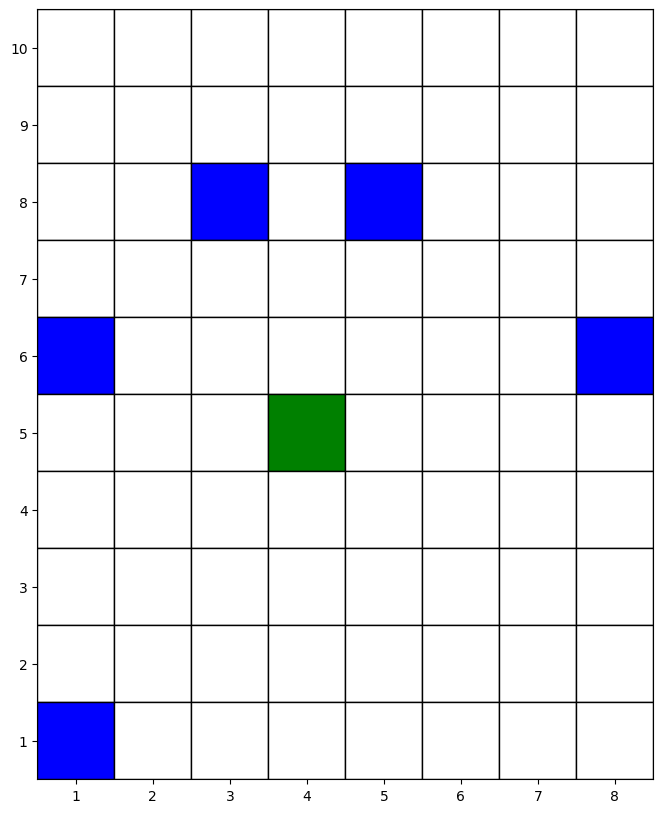


Tổng đường đi: 20
Tổng chi phí: 72
Bước 0: (5, 4)
Bước 1: (6, 4)
Bước 2: (7, 4)
Bước 3: (8, 3)
Bước 4: (7, 2)
Bước 5: (6, 1)
Bước 6: (6, 2)
Bước 7: (6, 3)
Bước 8: (7, 4)
Bước 9: (8, 5)
Bước 10: (8, 6)
Bước 11: (7, 7)
Bước 12: (6, 8)
Bước 13: (6, 7)
Bước 14: (6, 6)
Bước 15: (5, 5)
Bước 16: (4, 4)
Bước 17: (3, 3)
Bước 18: (2, 2)
Bước 19: (1, 1)


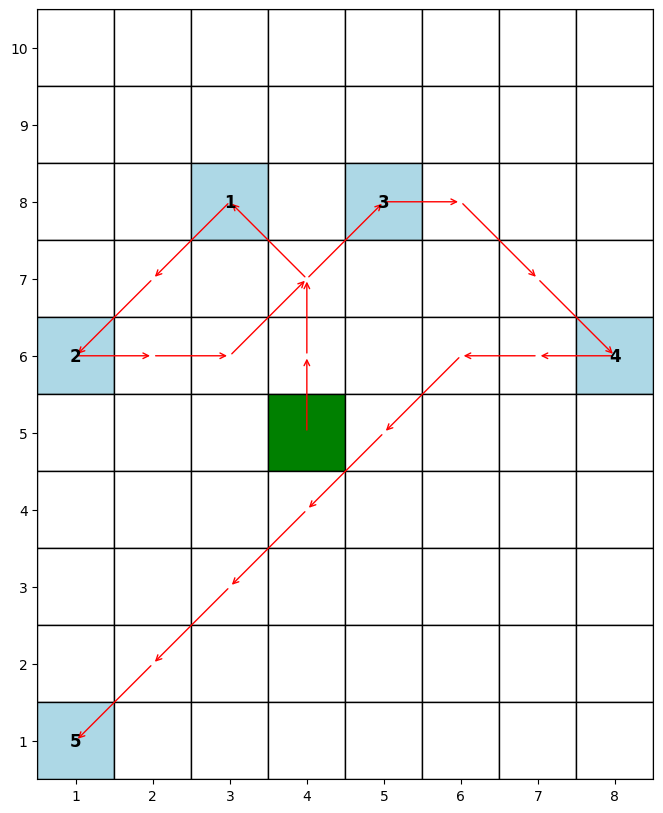

In [ ]:
# Chỉ định ví trí cụ thể của dirty_pos và start_pos
dirty_pos = [Position(1,1), Position(6,1), Position(8,3), Position(8,5), Position(6,8)]
start_pos = Position(5,4)
test_grid = Grid(10, 8, dirty_pos, start_pos)
test_robot = Robot(test_grid)
test_grid.display_grid()

total_path, total_cost = test_robot.clean_all(display=False)
print(f"\nTổng đường đi: {len(total_path)}")
print(f"Tổng chi phí: {total_cost}")
for i, cell in enumerate(total_path):
    print(f"Bước {i}: {cell.position}")

test_grid.display_grid(total_path)

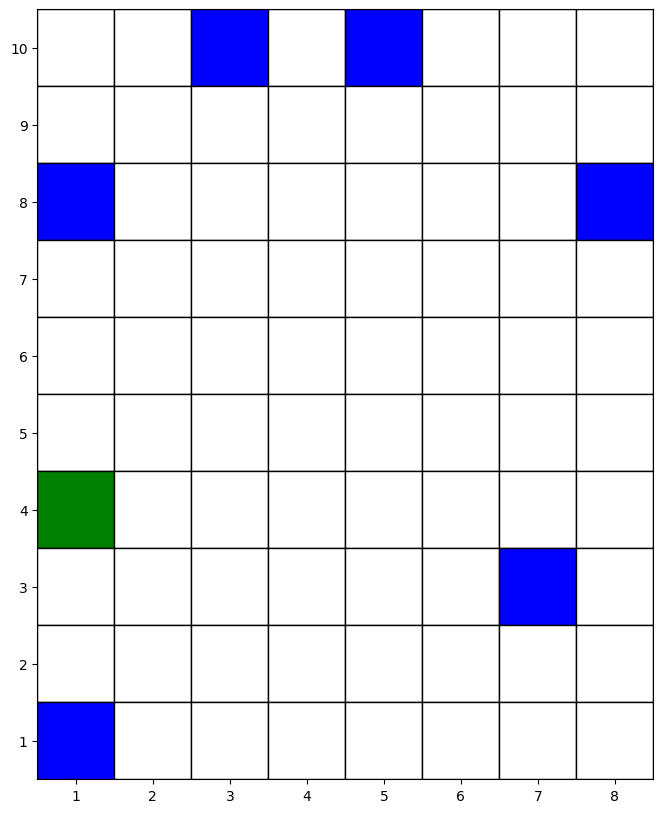


Tổng đường đi: 22
Tổng chi phí: 110
Bước 0: (4, 1)
Bước 1: (3, 1)
Bước 2: (2, 1)
Bước 3: (1, 1)
Bước 4: (1, 2)
Bước 5: (1, 3)
Bước 6: (1, 4)
Bước 7: (1, 5)
Bước 8: (2, 6)
Bước 9: (3, 7)
Bước 10: (4, 7)
Bước 11: (5, 7)
Bước 12: (6, 7)
Bước 13: (7, 7)
Bước 14: (8, 8)
Bước 15: (8, 7)
Bước 16: (9, 6)
Bước 17: (10, 5)
Bước 18: (10, 4)
Bước 19: (10, 3)
Bước 20: (9, 2)
Bước 21: (8, 1)


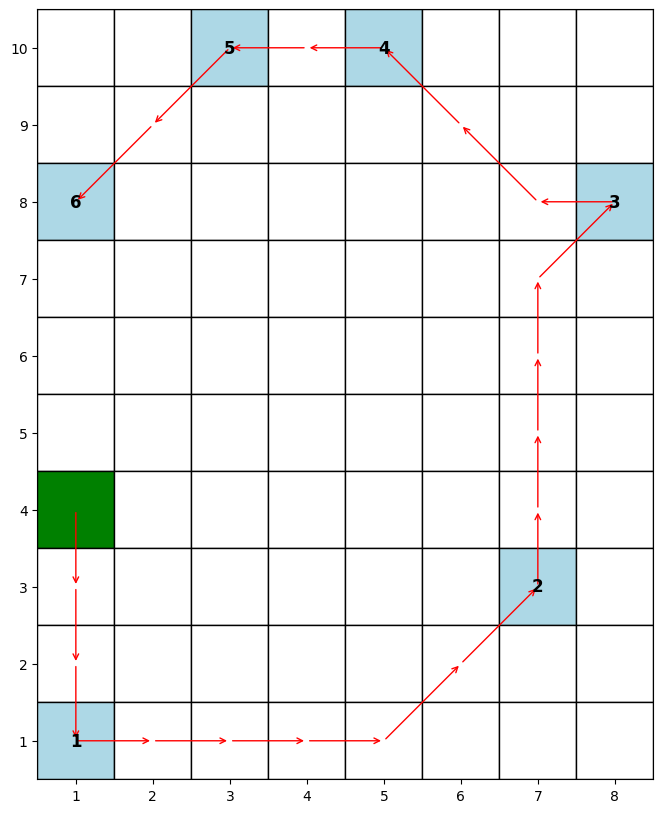

In [ ]:
# Chỉ định ví trí cụ thể của dirty_pos và start_pos
dirty_pos = [Position(1,1), Position(8,1), Position(10,3), Position(10,5), Position(8,8), Position(3,7)]
start_pos = Position(4,1)
test_grid = Grid(10, 8, dirty_pos, start_pos)
test_robot = Robot(test_grid)
test_grid.display_grid()

total_path, total_cost = test_robot.clean_all(display=False)
print(f"\nTổng đường đi: {len(total_path)}")
print(f"Tổng chi phí: {total_cost}")
for i, cell in enumerate(total_path):
    print(f"Bước {i}: {cell.position}")

test_grid.display_grid(total_path)

# **Ví dụ 2: Nhập kích thước ma trận, tạo ngẫu nhiên vị trí các ô dơ và ô bắt đầu**

Nhập kích thước ma trận (mxn): 50x50
Nhập số lượng ô dirty: 150


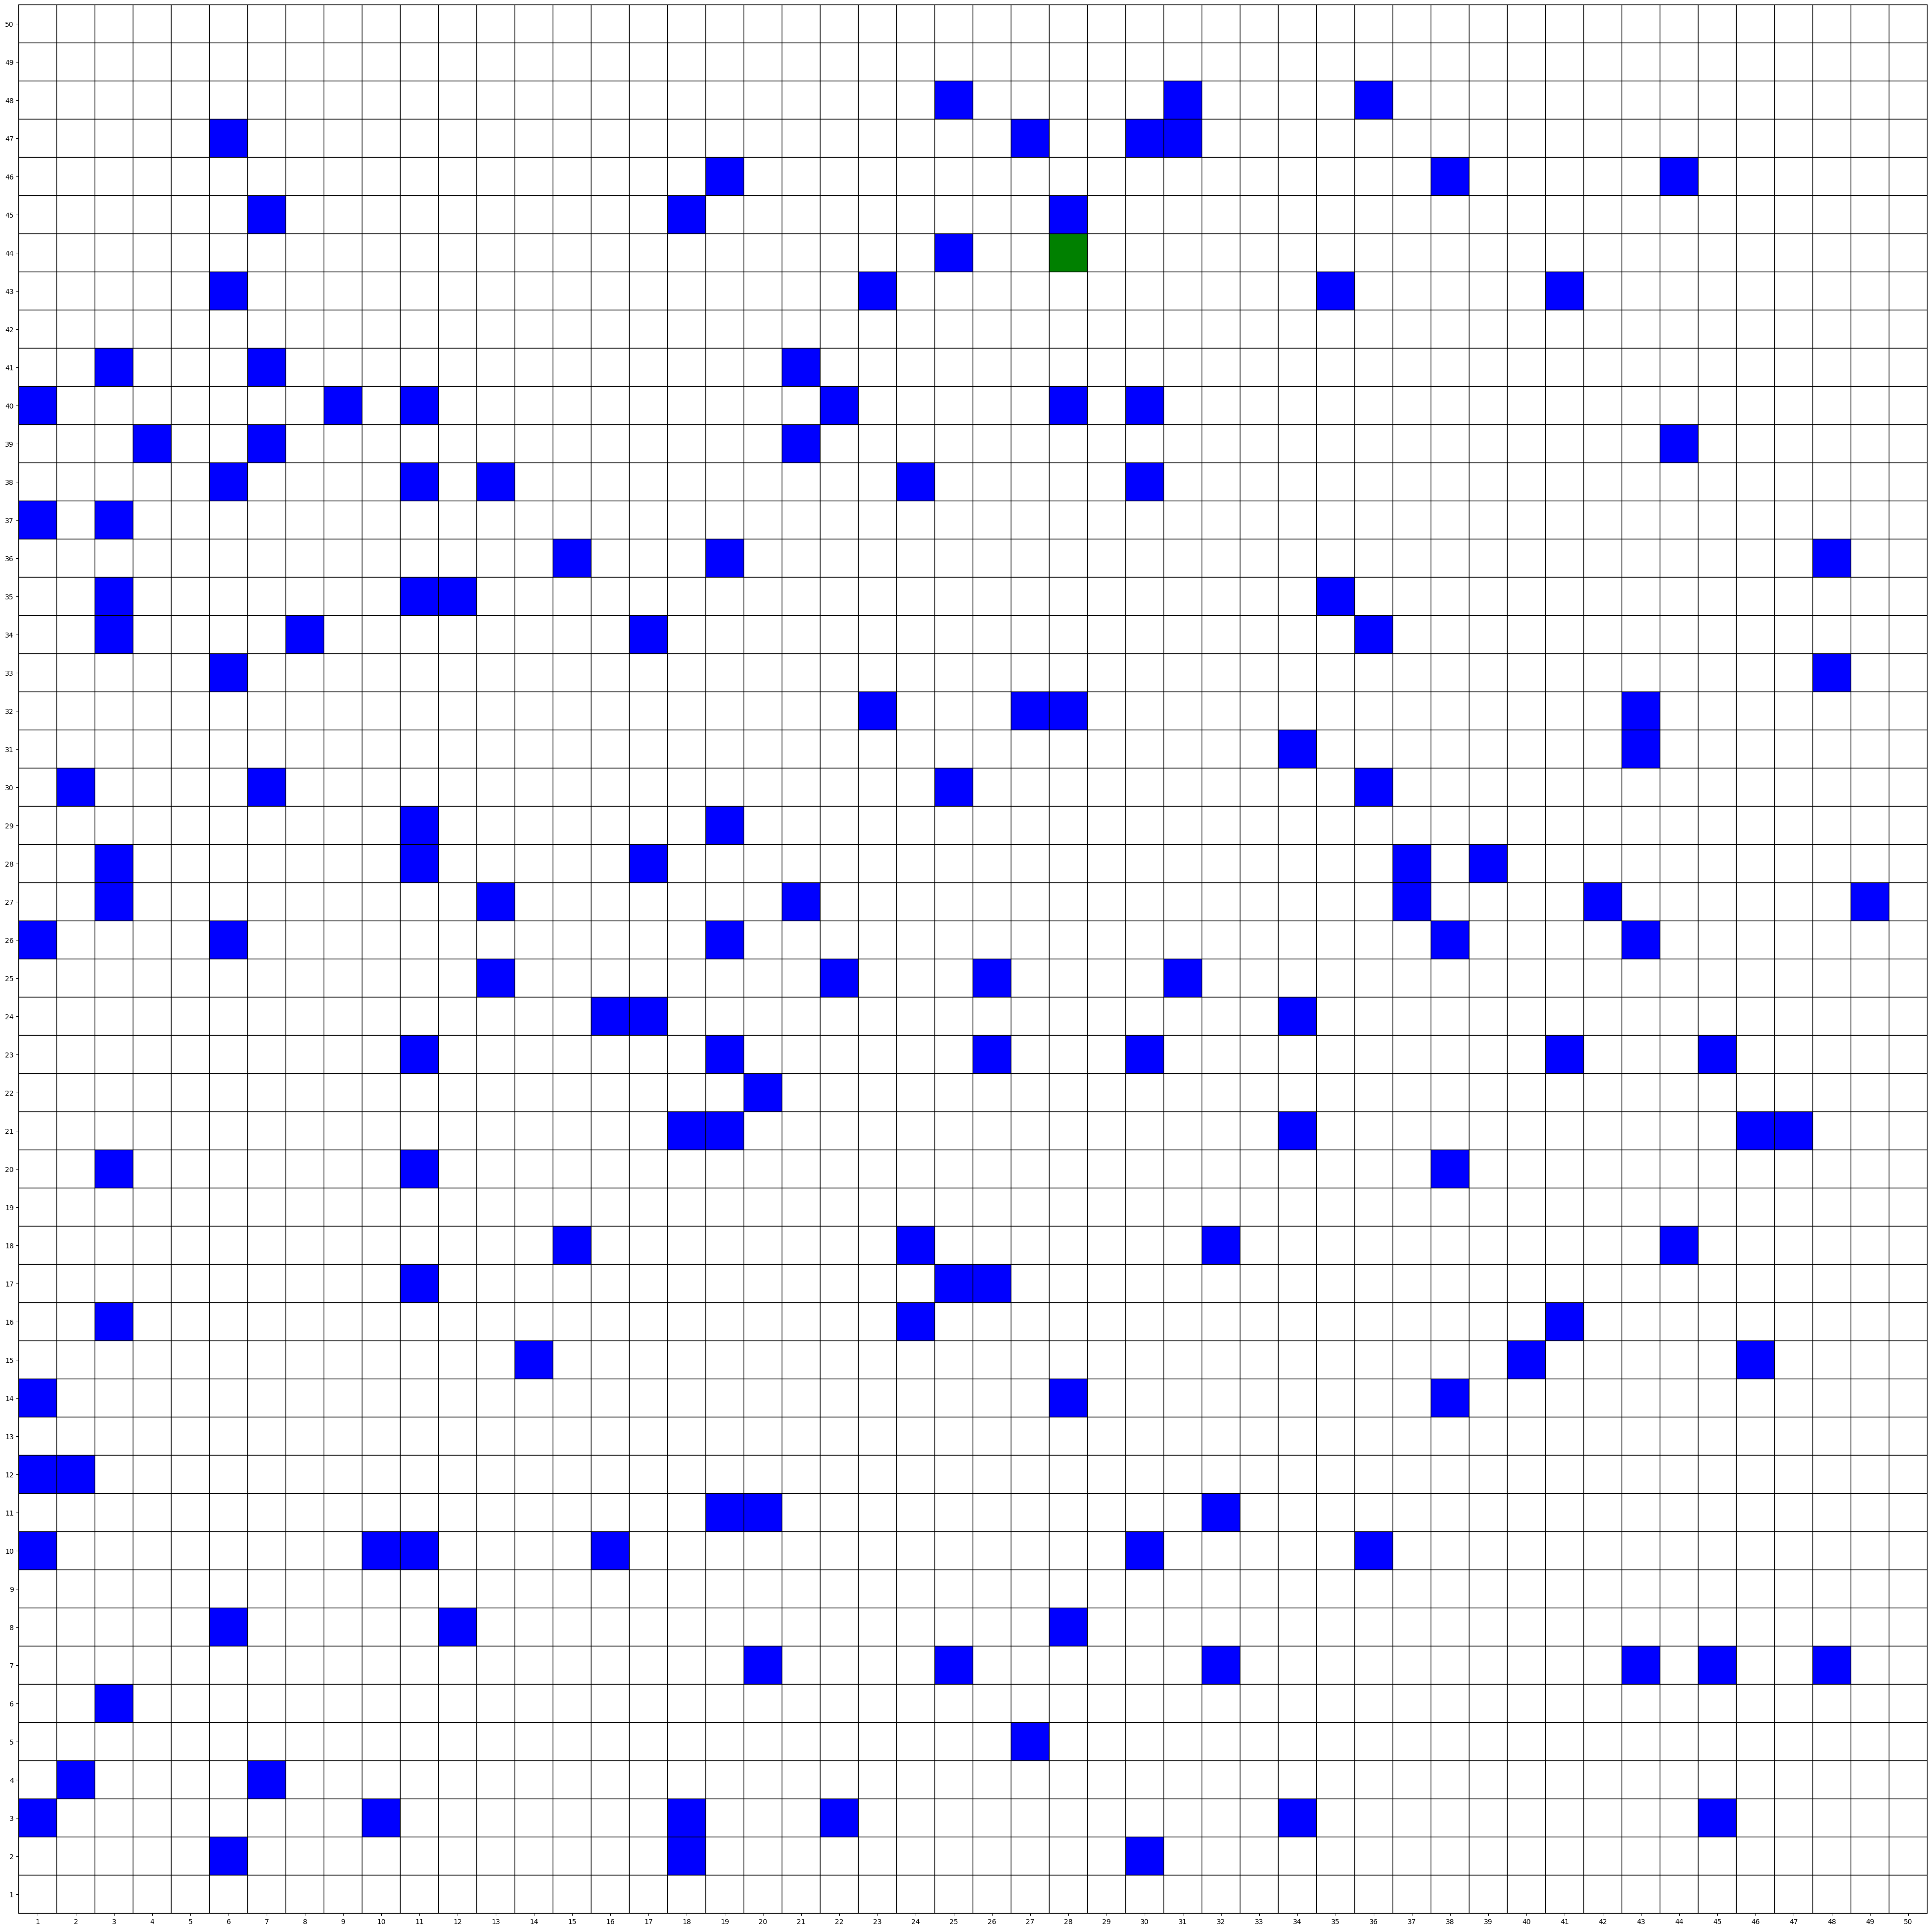


Tổng đường đi: 515
Tổng chi phí: 31702
Thời gian thực thi: 0.6948399543762207 giây


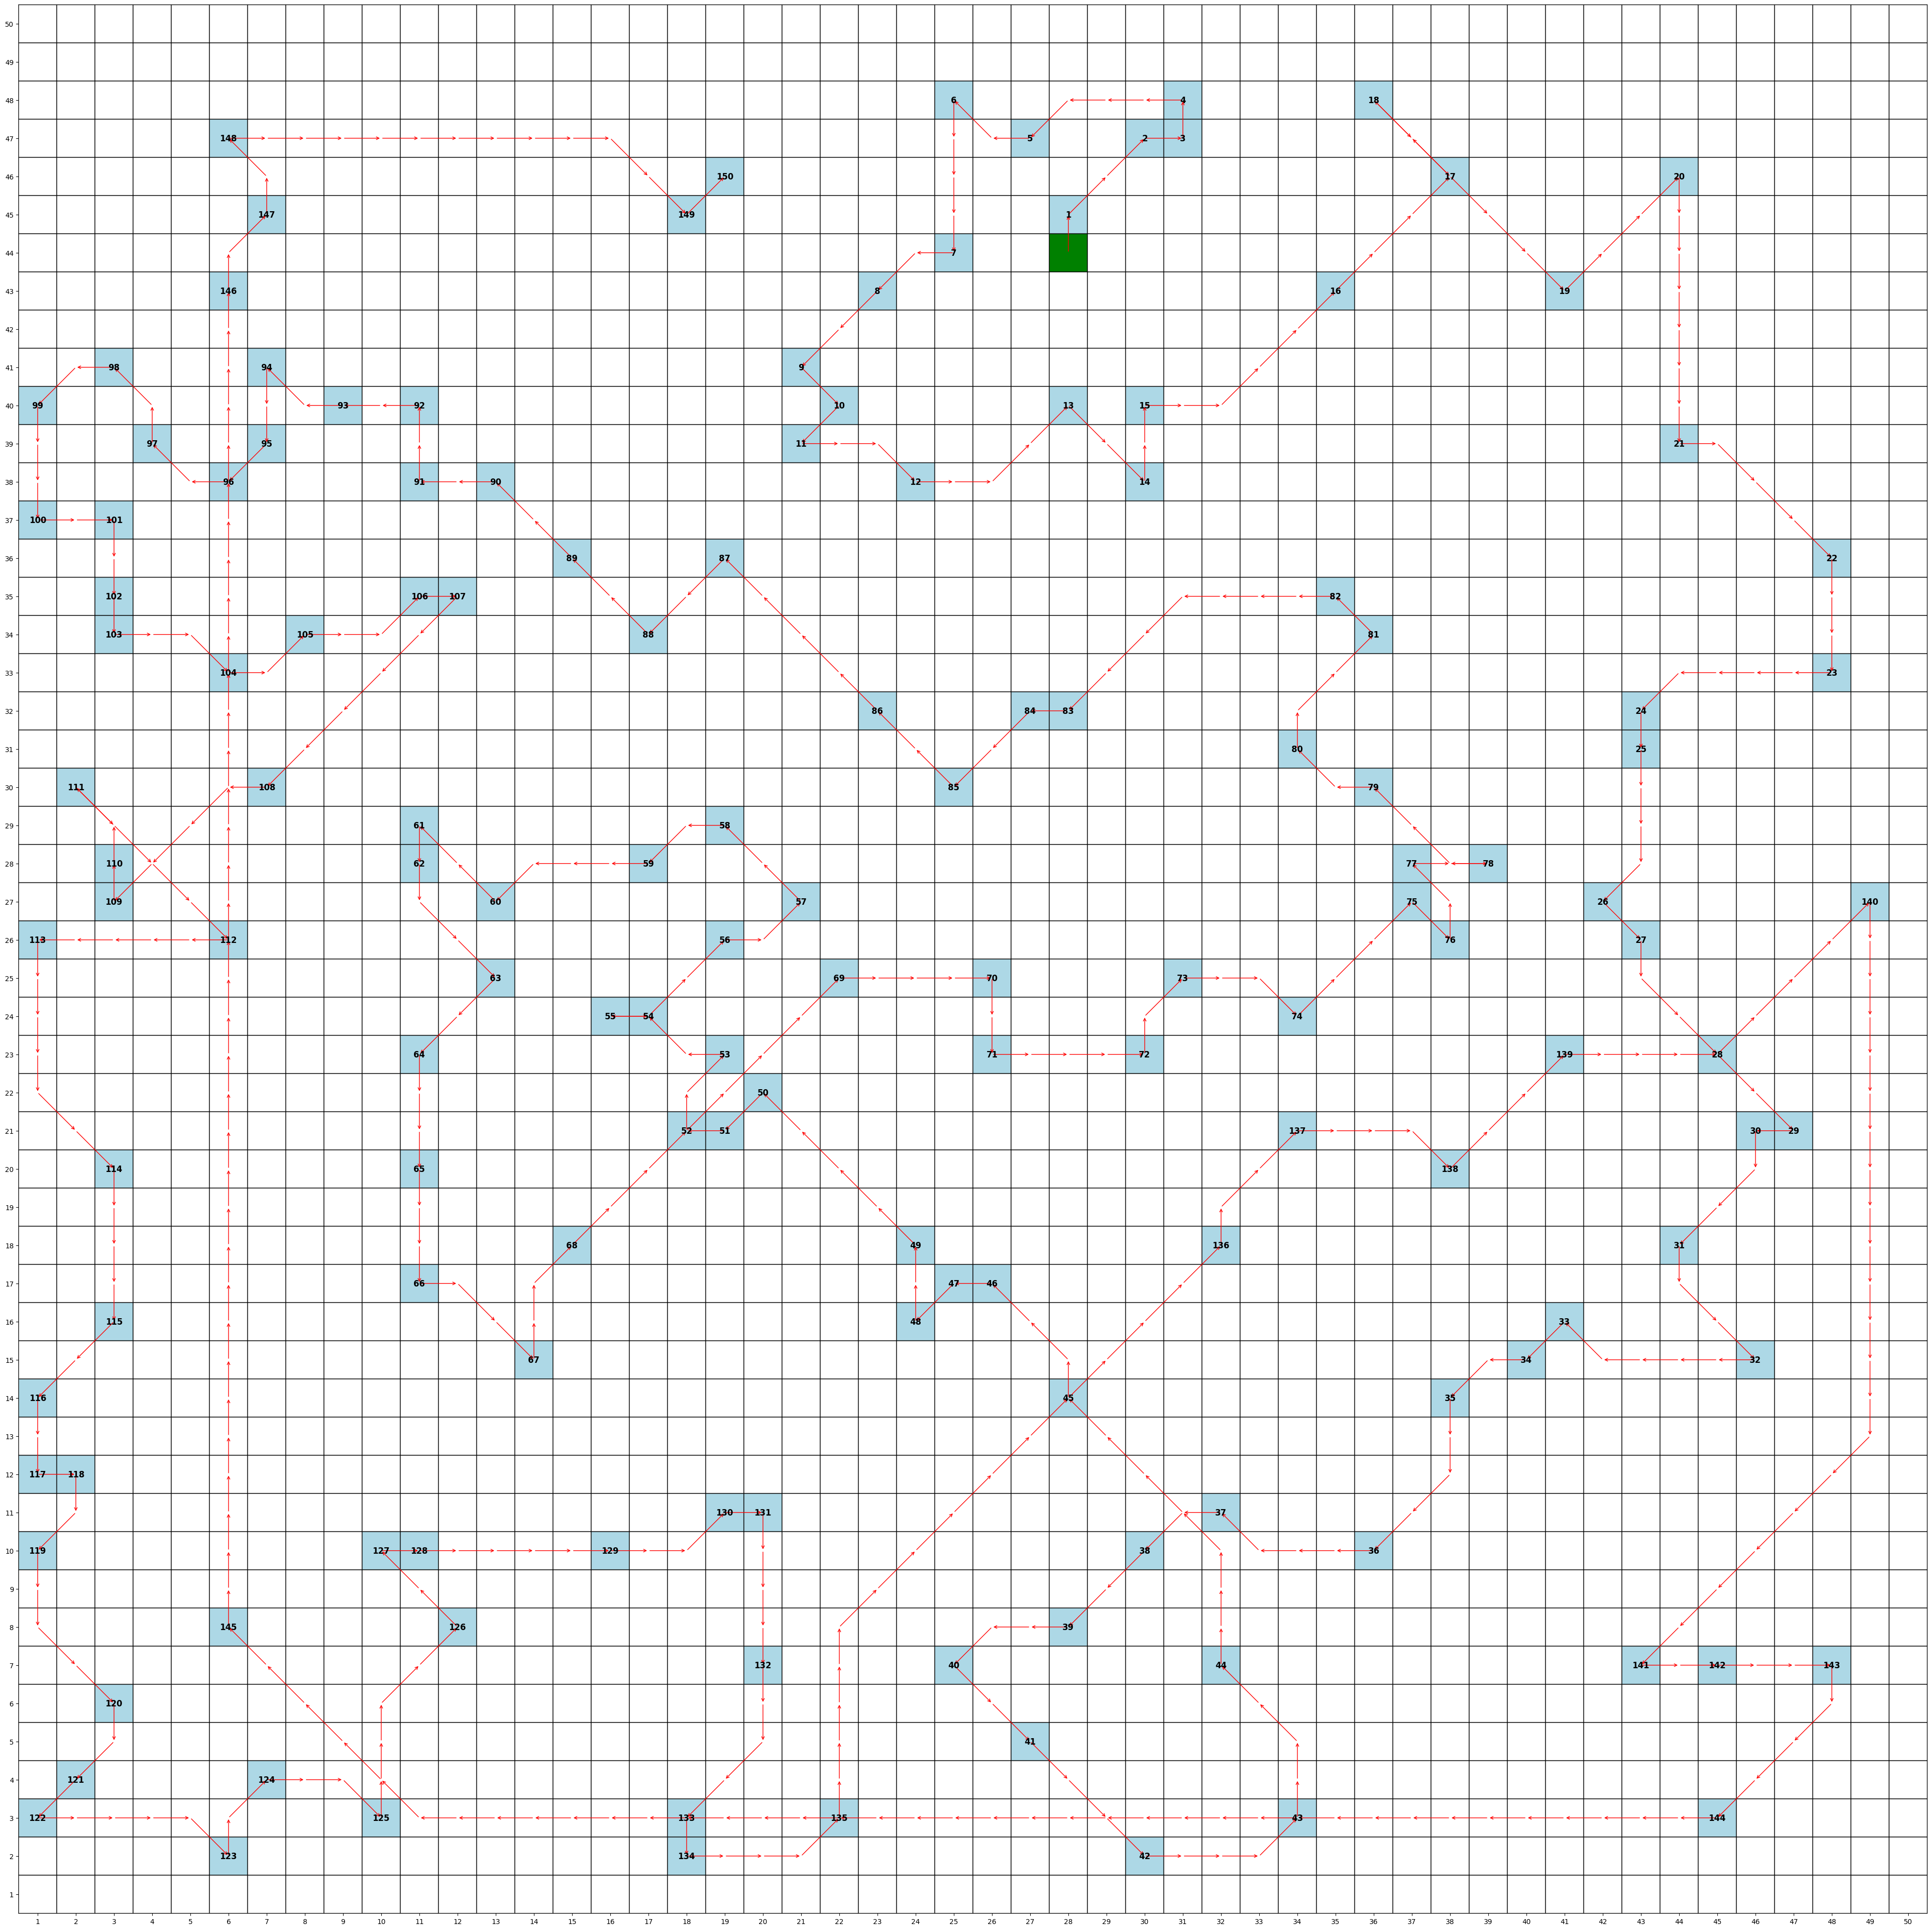

In [ ]:
# Nhập số, tạo ngẫu nhiên
test_grid = Grid.create_grid()

test_robot = Robot(test_grid)
test_grid.display_grid()

start_time = time.time()
total_path, total_cost = test_robot.clean_all(display=False)
end_time = time.time()

print(f"\nTổng đường đi: {len(total_path)}")
print(f"Tổng chi phí: {total_cost}")
# for i, cell in enumerate(total_path):
#     print(f"Bước {i}: {cell.position}")

print(f"Thời gian thực thi: {end_time - start_time} giây")
test_grid.display_grid(total_path)